In [1]:
# importer le notebook des fonctions utiles et des importations nécessaires
import nbimporter
from functions_and_imports import *

In [2]:
data = pd.read_csv('../../data/df_6H_imputed_with_knn.csv')
display_basic_info(data)

Shape of the DataFrame: (35064, 39)

Number of unique patients: 5844

SepsisLabel class counts:
 SepsisLabel
1.0    17532
0.0    17532
Name: count, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    2922
1.0    2922
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                float64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP         

In [3]:
# split
train_df, test_df = split_train_test_data_v2(data) 

# Extraction de séquences et normalisation
normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, scaler = extract_sequences_and_normalize(train_df, test_df, exclude_columns=['Patient_ID', 'Hour', 'SepsisLabel'], drop_column ='will_have_sepsis', label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6)

functions_and_imports.ipynb:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    - sequences (list): Une liste de tableaux numpy représentant les séquences de caractéristiques.\n",
functions_and_imports.ipynb:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    - labels (list): Une liste d'étiquettes associées à chaque séquence.\n",


In [5]:
normalize_sequences_train.shape,labels_train.shape, normalize_sequences_test.shape,labels_test.shape

((4675, 6, 35), (4675,), (1169, 6, 35), (1169,))

In [15]:
def build_and_train_rnn_model(X_train, y_train, X_val, y_val, input_shape, epochs=300, batch_size=128):
    """
    Construit et entraîne un modèle RNN pour la prédiction basée sur des données séquentielles.

    Args:
    - X_train: Séquences d'entraînement (padded).
    - y_train: Labels d'entraînement.
    - X_val: Séquences de validation (padded).
    - y_val: Labels de validation.
    - input_shape: Tuple représentant la forme des données d'entrée (time_steps, features).
    - epochs: Nombre d'époques d'entraînement.
    - batch_size: Taille du lot pour l'entraînement.

    Returns:
    - keras.models.Model: Modèle RNN entraîné.
    - keras.callbacks.History: Historique de l'entraînement.
    """
    model = Sequential([
        SimpleRNN(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.25),
        SimpleRNN(64),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dropout(0.25),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Configuration de l'arrêt prématuré
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)
    
    # Entraînement du modèle
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

    return model, history


In [16]:
input_shape = (6, 35)  # time steps, features
model, history = build_and_train_rnn_model(normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, input_shape)

Epoch 1/300


C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.5103 - loss: 0.7456 - val_accuracy: 0.5141 - val_loss: 0.6820
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5117 - loss: 0.7089 - val_accuracy: 0.5304 - val_loss: 0.6732
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5428 - loss: 0.6959 - val_accuracy: 0.6570 - val_loss: 0.6601
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5546 - loss: 0.6861 - val_accuracy: 0.6912 - val_loss: 0.6432
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5752 - loss: 0.6737 - val_accuracy: 0.7322 - val_loss: 0.6147
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6149 - loss: 0.6502 - val_accuracy: 0.7802 - val_loss: 0.5661
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6722 - loss: 0.6133 - val_accuracy: 0.7981 - val_loss: 0.5004
Epoch 8/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7400 - loss: 0.5559 - val_accuracy: 0.8204 - val_l

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8677 - loss: 0.3233 - val_accuracy: 0.8708 - val_loss: 0.3148
Epoch 52/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8611 - loss: 0.3147 - val_accuracy: 0.8794 - val_loss: 0.3059
Epoch 53/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8709 - loss: 0.3088 - val_accuracy: 0.8854 - val_loss: 0.3046
Epoch 54/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8638 - loss: 0.3147 - val_accuracy: 0.8828 - val_loss: 0.3031
Epoch 55/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8673 - loss: 0.3182 - val_accuracy: 0.8854 - val_loss: 0.3022
Epoch 56/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8692 - loss: 0.2931 - val_accuracy: 0.8785 - val_loss: 0.3057
Epoch 57/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8671 - loss: 0.3043 - val_accuracy: 0.8854 - val_loss: 0.3011
Epoch 58/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8781 - loss: 0.2949 - val_accuracy: 0.8794 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8780 - loss: 0.2890 - val_accuracy: 0.8914 - val_loss: 0.3054
Epoch 102/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8745 - loss: 0.2951 - val_accuracy: 0.8931 - val_loss: 0.2899
Epoch 103/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8875 - loss: 0.2797 - val_accuracy: 0.8879 - val_loss: 0.2931
Epoch 104/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8801 - loss: 0.2859 - val_accuracy: 0.8905 - val_loss: 0.2892
Epoch 105/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8902 - loss: 0.2670 - val_accuracy: 0.8948 - val_loss: 0.2910
Epoch 106/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8821 - loss: 0.2835 - val_accuracy: 0.8905 - val_loss: 0.2879
Epoch 107/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8798 - loss: 0.2848 - val_accuracy: 0.8931 - val_loss: 0.2896
Epoch 108/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8792 - loss: 0.2889 - val_accuracy: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8887 - loss: 0.2706 - val_accuracy: 0.8991 - val_loss: 0.2771
Epoch 152/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8888 - loss: 0.2647 - val_accuracy: 0.8999 - val_loss: 0.2773
Epoch 153/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8949 - loss: 0.2650 - val_accuracy: 0.8982 - val_loss: 0.2776
Epoch 154/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8833 - loss: 0.2796 - val_accuracy: 0.8956 - val_loss: 0.2807
Epoch 155/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8905 - loss: 0.2654 - val_accuracy: 0.8999 - val_loss: 0.2772
Epoch 156/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8891 - loss: 0.2674 - val_accuracy: 0.9008 - val_loss: 0.2798
Epoch 157/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8932 - loss: 0.2535 - val_accuracy: 0.8999 - val_loss: 0.2772
Epoch 158/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8937 - loss: 0.2753 - val_accuracy: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8939 - loss: 0.2586 - val_accuracy: 0.9059 - val_loss: 0.2702
Epoch 202/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8890 - loss: 0.2670 - val_accuracy: 0.8956 - val_loss: 0.2769
Epoch 203/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8974 - loss: 0.2488 - val_accuracy: 0.9033 - val_loss: 0.2684
Epoch 204/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9020 - loss: 0.2524 - val_accuracy: 0.8837 - val_loss: 0.2966
Epoch 205/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8927 - loss: 0.2559 - val_accuracy: 0.8973 - val_loss: 0.2835
Epoch 206/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8927 - loss: 0.2683 - val_accuracy: 0.9042 - val_loss: 0.2740
Epoch 207/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8953 - loss: 0.2605 - val_accuracy: 0.9033 - val_loss: 0.2699
Epoch 208/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8955 - loss: 0.2529 - val_accuracy: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8989 - loss: 0.2429 - val_accuracy: 0.8965 - val_loss: 0.2741
Epoch 252/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8997 - loss: 0.2458 - val_accuracy: 0.9085 - val_loss: 0.2642
Epoch 253/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8880 - loss: 0.2750 - val_accuracy: 0.8931 - val_loss: 0.2776
Epoch 254/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8968 - loss: 0.2536 - val_accuracy: 0.9085 - val_loss: 0.2631
Epoch 255/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9005 - loss: 0.2395 - val_accuracy: 0.9110 - val_loss: 0.2626
Epoch 256/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9036 - loss: 0.2474 - val_accuracy: 0.9093 - val_loss: 0.2644
Epoch 257/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9027 - loss: 0.2475 - val_accuracy: 0.9110 - val_loss: 0.2632
Epoch 258/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9079 - loss: 0.2352 - val_accuracy: 0

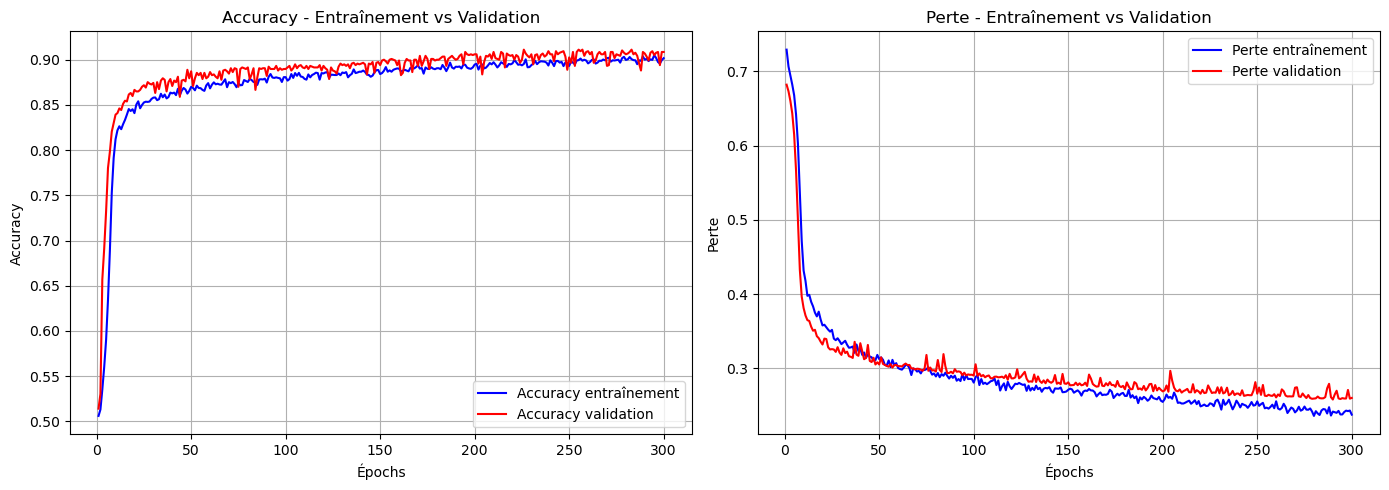

In [17]:
plot_training_history(history)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Accuracy: 0.9068
Precision: 0.9041
Recall: 0.9147
F1-Score: 0.9094
AUROC: 0.9625


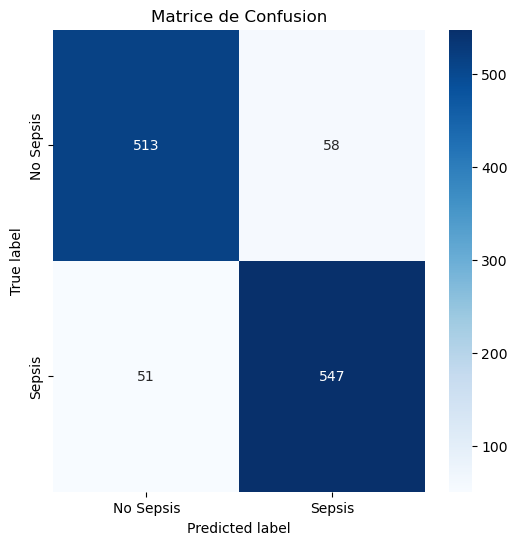

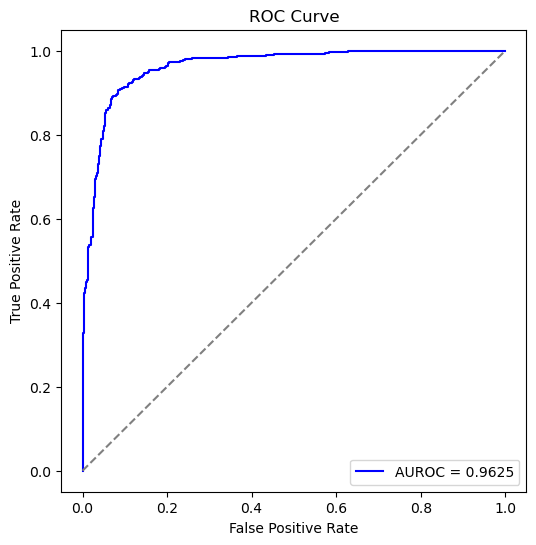

In [18]:
# Évaluer les performances du modèle sur les données de test
predict_prob, predict = evaluate_model_performance(model, normalize_sequences_test, labels_test)